<a href="https://colab.research.google.com/github/Pheeraya/dupmeGame/blob/master/model_training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Constants

In [ ]:
## Change these values as wishes

# Model Constants
RAND_SEED = 42

# Display Constants
TRAIN_PROGRESS = 4   # verbose param in GridSearchCV

# Installation

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 7.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import altair as alt

In [ ]:
from IPython.display import display

def show_more(df, lines):
  temp = pd.options.display.max_rows
  pd.options.display.max_rows = lines
  display(df)
  pd.options.display.max_rows = temp

# User-defined Functions

In [ ]:
def np2df(x1, x2, y1, y2, xcols):
  x1 = pd.DataFrame(x1, columns=xcols)
  x2 = pd.DataFrame(x2, columns=xcols)
  y1 = pd.DataFrame(y1)
  y2 = pd.DataFrame(y2)
  return x1, x2, y1, y2

In [ ]:
def date2duration(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col])
    df[col] = (pd.Timestamp.now() - df[col]).astype('timedelta64[D]')

In [ ]:
from sklearn.impute import SimpleImputer

def impute_median(df, cols, imp=None):
  if imp == None:
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(df[cols])
  df[cols] = imp.transform(df[cols])
  return imp

def impute_mean(df, cols, imp=None):
  if imp == None:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(df[cols])
  df[cols] = imp.transform(df[cols])
  return imp

def impute_mode(df, cols, imp=None):
  if imp == None:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(df[cols])
  df[cols] = imp.transform(df[cols])
  return imp

def impute_zeros(df, cols, imp=None):
  if imp == None:
    imp = SimpleImputer(missing_values=np.nan, fill_value=0, strategy='constant')
    imp.fit(df[cols])
  df[cols] = imp.transform(df[cols])
  return imp

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def encode_fit(df, cols):
  enc = OneHotEncoder(handle_unknown = 'ignore')
  enc.fit(df[cols])
  return enc

def encode(df, cols, enc):
  start_ind = df.shape[1] - len(cols)
  dummies = pd.DataFrame(enc.transform(df[cols]).toarray(), columns=enc.get_feature_names(cols), index=df.index)
  df = pd.concat([df, dummies], axis=1)
  df = df.drop(cols, axis=1)
  return df, [start_ind + i for i in range(dummies.shape[1])]

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale(df, sc=None):
  if sc == None:
    sc = StandardScaler()
  df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
  return df, sc

### Function Stack when end2endTrainTest is called

end2endTrainTest()
* train_model()
* evaluate()
  * disp_confusion_matrix()
  * disp_roc_curve()
* disp_shap()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV

def train_model(model, X, Y, params, splits=5):
  scorers = {
        'accuracy_score': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score),
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'auc_score': make_scorer(roc_auc_score)
      }

  skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=RAND_SEED)
  grid = GridSearchCV(model, param_grid = params, scoring = scorers, n_jobs = -1, 
                      cv = skf.split(X, Y), refit = 'auc_score', verbose=TRAIN_PROGRESS)
  grid.fit(X, Y)
  acc_scores = grid.cv_results_["mean_test_accuracy_score"]
  f1_scores = grid.cv_results_["mean_test_f1_score"]
  pre_scores = grid.cv_results_["mean_test_precision_score"]
  rec_scores = grid.cv_results_["mean_test_recall_score"]
  auc_scores = grid.cv_results_["mean_test_auc_score"]

  print("------------------------Training Validation-----------------------")
  print("acc_score:", acc_scores)
  print("f1_score:", f1_scores)
  print("pre_score:", pre_scores)
  print("rec_score:", rec_scores)
  print("auc_score:", auc_scores)
  print("Best Params:", grid.best_params_)
  print("------------------------------------------------------------------")

  return grid.best_estimator_

In [ ]:
from sklearn.metrics import confusion_matrix

def disp_confusion_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  display(sb.heatmap(cf_matrix, annot=labels, fmt=""))
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate(model, x_test, y_test):
  y_pred = model.predict(x_test)
  print("------------------------------Testing-----------------------------")
  print("acc_score:", accuracy_score(y_test, y_pred))
  print("f1_score:", f1_score(y_test, y_pred))
  print("pre_score:", precision_score(y_test, y_pred))
  print("rec_score:", recall_score(y_test, y_pred))
  print("auc_score:", roc_auc_score(y_test, y_pred))
  print("------------------------------------------------------------------")

  disp_confusion_matrix(y_test, y_pred)

In [ ]:
import shap

def disp_shap(model, explainer, x_test):
  shap_values = explainer.shap_values(x_test)
  display(shap.summary_plot(shap_values, features=x_test, feature_names=x_test.columns))
  display(shap.summary_plot(shap_values, features=x_test, feature_names=x_test.columns, plot_type='bar'))

In [ ]:
from sklearn.model_selection import train_test_split

def end2endTrainTest(x_train, y_train, x_test, y_test, model, gridCV_params, splits=5, explainer_constructor=shap.Explainer):
  model = train_model(model, x_train, y_train, gridCV_params, splits=splits)
  evaluate(model, x_test, y_test)

  disp_shap(model, explainer_constructor(model), x_test)

  return model

# Example

In [ ]:
# Read Data
df = pd.read_csv("/content/drive/Shareddrives/aihack/preped_data.csv")
df = df.sample(frac=1).reset_index(drop=True)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


['number_of_children', 'number_of_resident', 'c_monthly_salary', 'c_salary_payment_methods', 'r_expected_credit_limit', 'r_allloan_amount', 'r_additional_income', 'r_spouse_income', 'credit_limit_ratio', 'APP_Area_Bangkok Metropolitan Region', 'APP_Area_Central', 'APP_Area_East', 'APP_Area_North', 'APP_Area_Northeast', 'APP_Area_South', 'APP_Area_Thaicredit', 'APP_Area_West', 'APP_Area_webpak', 'APP_Province_Ang Thong', 'APP_Province_Bangkok', 'APP_Province_Buri Ram', 'APP_Province_Chachoengsao', 'APP_Province_Chanthaburi', 'APP_Province_Chiang Mai', 'APP_Province_Chiang Rai', 'APP_Province_Chon Buri', 'APP_Province_Kamphaeng Phet', 'APP_Province_Kanchanaburi', 'APP_Province_Khon Kaen', 'APP_Province_Krabi', 'APP_Province_Lampang', 'APP_Province_Lamphun', 'APP_Province_Lop Buri', 'APP_Province_Maha Sarakham', 'APP_Province_Mukdahan', 'APP_Province_Nakhon Pathom', 'APP_Province_Nakhon Ratchasima', 'APP_Province_Nakhon Sawan', 'APP_Province_Nakhon Si Thammarat', 'APP_Province_Nan', 'APP_

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


------------------------Training Validation-----------------------
acc_score: [0.8610703]
f1_score: [0.85792703]
pre_score: [0.87776748]
rec_score: [0.83899485]
auc_score: [0.86107056]
Best Params: {'max_depth': 9, 'n_estimators': 1000, 'penalty': 'l1'}
------------------------------------------------------------------
------------------------------Testing-----------------------------
acc_score: 0.505911330049261
f1_score: 0.28357142857142853
pre_score: 0.1842227378190255
rec_score: 0.6155038759689923
auc_score: 0.5503580873256382
------------------------------------------------------------------


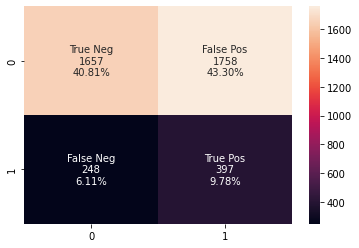

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


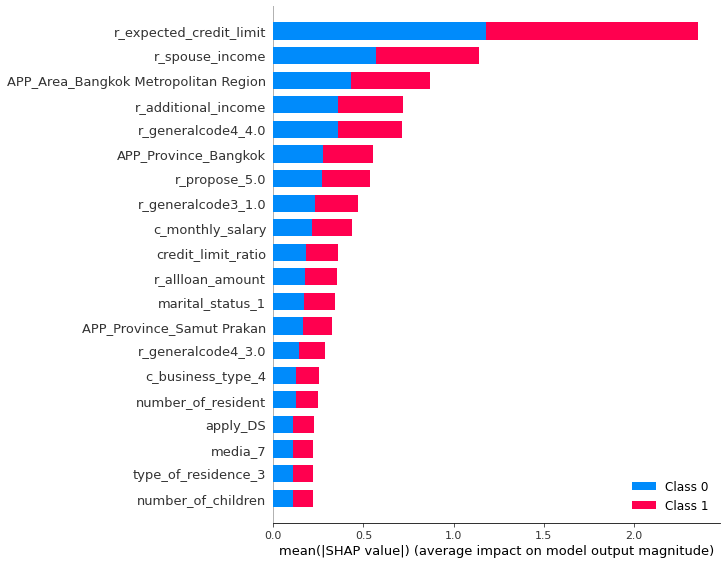

None

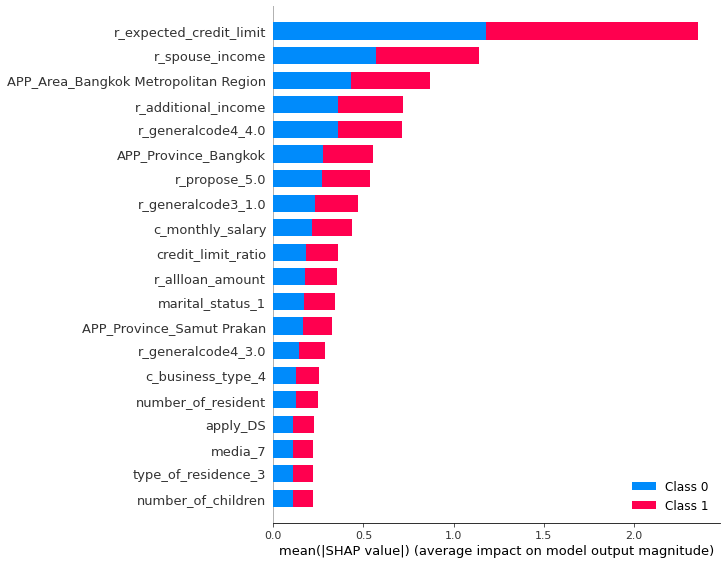

None

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC

# Drop Column & Feature Eng
drop_cols = ["date_of_birth","default_12month","first_WD_date",'c_number_of_working_month',
             'r_allloan_case',"customer_no",'c_number_of_employee', "APP_date", "date_of_birth_week",
             'living_period_month', "postal_code", "c_postal_code", "status", "c_date_of_salary_payment", 
             "c_number_of_working_year", "living_period_year"]
date_cols = []
impute_mode_cols = ["r_propose", "r_spouse_income", "r_generalcode1", "r_generalcode2",
                    "r_generalcode3", "r_generalcode4", "r_generalcode5"]
impute_mean_cols = ["r_expected_credit_limit", "credit_limit_ratio"]
impute_zeros_cols = ["r_spouse_income", "r_additional_income"]
encode_cols = ["APP_Area", "APP_Province", "APP_Shop Name", "gender", "marital_status",
               "tel_category", "type_of_residence", "c_business_type", "c_position", "c_occupation",
               "c_employment_status", "media", "place_for_sending_information", "r_propose", "r_generalcode1",
               "r_generalcode2", "r_generalcode3", "r_generalcode4", "r_generalcode5", "apply"]

df['credit_limit_ratio'] = df['r_expected_credit_limit'] / df['c_monthly_salary']
# df["c_number_of_working_month"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
# df["living_period_month"] = df["living_period_year"] * 12 + df["living_period_month"]

# Train-test Split
x = df.drop(columns=drop_cols)
y = df["default_12month"]
enc = encode_fit(x, encode_cols)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RAND_SEED, stratify=y)
x_train, x_test, y_train, y_test = np2df(x_train, x_test, y_train, y_test, xcols=x.columns)

# Preprocessing
date2duration(x_train, date_cols)
imp_mode = impute_mode(x_train, impute_mode_cols)
imp_mean = impute_mean(x_train, impute_mean_cols)
imp_zeros = impute_zeros(x_train, impute_zeros_cols)

date2duration(x_test, date_cols)
impute_mode(x_test, impute_mode_cols, imp=imp_mode)
impute_mean(x_test, impute_mean_cols, imp=imp_mean)
impute_zeros(x_test, impute_zeros_cols, imp=imp_zeros)

encode_indices = [x_train.columns.get_loc(c) for c in encode_cols if c in x_train]
smote = SMOTENC(categorical_features=encode_indices, random_state=RAND_SEED)
x_train, y_train = smote.fit_resample(x_train, y_train)
x_train, x_test, y_train, y_test = np2df(x_train, x_test, y_train, y_test, xcols=x.columns)

x_train, _ = encode(x_train, encode_cols, enc)
x_test, _ = encode(x_test, encode_cols, enc)
x_train, sc = scale(x_train)
x_test, _ = scale(x_test, sc=sc)

# Train-Test-Analysis
# model = xgb.XGBClassifier()
model = lgb.LGBMClassifier()
params = {'penalty' :['l1'],'max_depth':[9],'n_estimators': [1000]}
print(list(x_train))
model = end2endTrainTest(x_train, y_train, x_test, y_test, model, params, splits=5, explainer_constructor=shap.TreeExplainer)

In [ ]:
# Prediction & Save Answer File

from google.colab import files

df_validate = pd.read_csv("/content/drive/Shareddrives/aihack/verification_nonflag.csv")
x_validate = df_validate.drop(columns=drop_cols)
x_validate['credit_limit_ratio'] = x_validate['r_expected_credit_limit'] / x_validate['c_monthly_salary']

date2duration(x_validate, date_cols)
impute_mode(x_validate, impute_mode_cols, imp=imp_mode)
impute_mean(x_validate, impute_mean_cols, imp=imp_mean)
impute_zeros(x_validate, impute_zeros_cols, imp=imp_zeros)
x_validate, _ = encode(x_validate, encode_cols, enc=enc)
x_validate, _ = scale(x_validate, sc=sc)

df_ans = pd.read_csv("/content/drive/Shareddrives/aihack/verification_nonflag.csv")
df_ans["default_12month"] = model.predict_proba(x_validate)
df_ans.to_csv("answer.csv", index=False)
files.download('answer.csv')

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


['number_of_children', 'number_of_resident', 'c_monthly_salary', 'c_salary_payment_methods', 'r_expected_credit_limit', 'r_allloan_amount', 'r_additional_income', 'r_spouse_income', 'credit_limit_ratio', 'APP_Area_Bangkok Metropolitan Region', 'APP_Area_Central', 'APP_Area_East', 'APP_Area_North', 'APP_Area_Northeast', 'APP_Area_South', 'APP_Area_Thaicredit', 'APP_Area_West', 'APP_Area_webpak', 'APP_Province_Ang Thong', 'APP_Province_Bangkok', 'APP_Province_Buri Ram', 'APP_Province_Chachoengsao', 'APP_Province_Chanthaburi', 'APP_Province_Chiang Mai', 'APP_Province_Chiang Rai', 'APP_Province_Chon Buri', 'APP_Province_Kamphaeng Phet', 'APP_Province_Kanchanaburi', 'APP_Province_Khon Kaen', 'APP_Province_Krabi', 'APP_Province_Lampang', 'APP_Province_Lamphun', 'APP_Province_Lop Buri', 'APP_Province_Maha Sarakham', 'APP_Province_Mukdahan', 'APP_Province_Nakhon Pathom', 'APP_Province_Nakhon Ratchasima', 'APP_Province_Nakhon Sawan', 'APP_Province_Nakhon Si Thammarat', 'APP_Province_Nan', 'APP_

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


------------------------Training Validation-----------------------
acc_score: [0.84163095]
f1_score: [0.83897704]
pre_score: [0.85322005]
rec_score: [0.82522987]
auc_score: [0.84163054]
Best Params: {'max_bin': 100, 'max_depth': 9, 'n_estimators': 1000, 'num_leaves': 10, 'penalty': 'l1'}
------------------------------------------------------------------
------------------------------Testing-----------------------------
acc_score: 0.5211822660098522
f1_score: 0.27081770442610653
pre_score: 0.17862444334487879
rec_score: 0.5596899224806201
auc_score: 0.5367995732461666
------------------------------------------------------------------


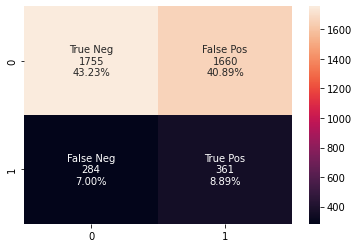

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


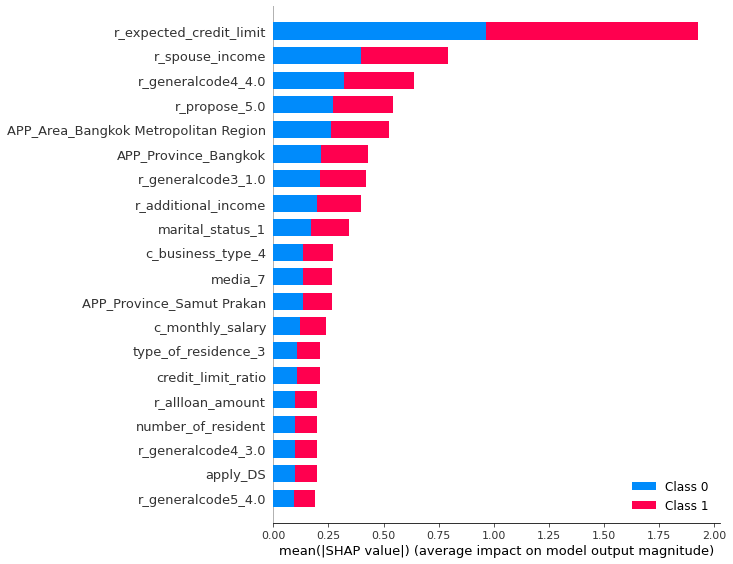

None

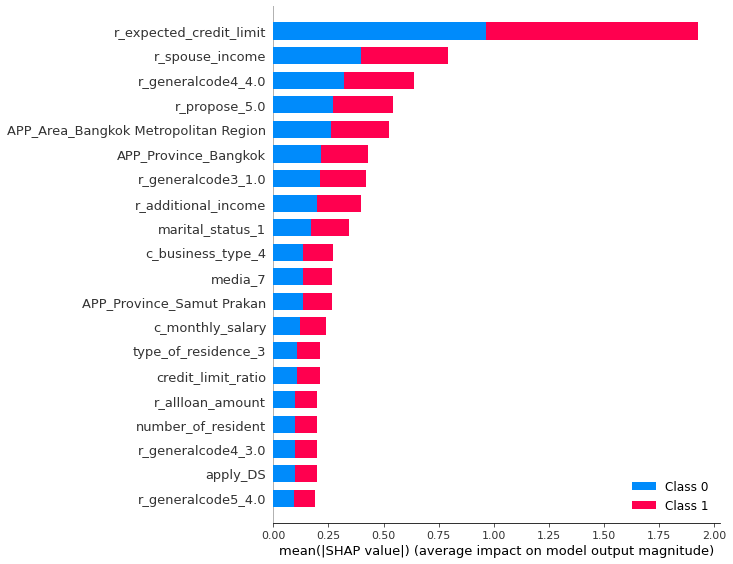

None

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC

# Drop Column & Feature Eng
drop_cols = ["date_of_birth","default_12month","first_WD_date",'c_number_of_working_month',
             'r_allloan_case',"customer_no",'c_number_of_employee', "APP_date", "date_of_birth_week",
             'living_period_month', "postal_code", "c_postal_code", "status", "c_date_of_salary_payment", 
             "c_number_of_working_year", "living_period_year"]
date_cols = []
impute_mode_cols = ["r_propose", "r_spouse_income", "r_generalcode1", "r_generalcode2",
                    "r_generalcode3", "r_generalcode4", "r_generalcode5"]
impute_mean_cols = ["r_expected_credit_limit", "credit_limit_ratio"]
impute_zeros_cols = ["r_spouse_income", "r_additional_income"]
encode_cols = ["APP_Area", "APP_Province", "APP_Shop Name", "gender", "marital_status",
               "tel_category", "type_of_residence", "c_business_type", "c_position", "c_occupation",
               "c_employment_status", "media", "place_for_sending_information", "r_propose", "r_generalcode1",
               "r_generalcode2", "r_generalcode3", "r_generalcode4", "r_generalcode5", "apply"]

df['credit_limit_ratio'] = df['r_expected_credit_limit'] / df['c_monthly_salary']
# df["c_number_of_working_month"] = df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
# df["living_period_month"] = df["living_period_year"] * 12 + df["living_period_month"]

# Train-test Split
x = df.drop(columns=drop_cols)
y = df["default_12month"]
enc = encode_fit(x, encode_cols)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RAND_SEED, stratify=y)
x_train, x_test, y_train, y_test = np2df(x_train, x_test, y_train, y_test, xcols=x.columns)

# Preprocessing
date2duration(x_train, date_cols)
imp_mode = impute_mode(x_train, impute_mode_cols)
imp_mean = impute_mean(x_train, impute_mean_cols)
imp_zeros = impute_zeros(x_train, impute_zeros_cols)

date2duration(x_test, date_cols)
impute_mode(x_test, impute_mode_cols, imp=imp_mode)
impute_mean(x_test, impute_mean_cols, imp=imp_mean)
impute_zeros(x_test, impute_zeros_cols, imp=imp_zeros)

encode_indices = [x_train.columns.get_loc(c) for c in encode_cols if c in x_train]
smote = SMOTENC(categorical_features=encode_indices, random_state=RAND_SEED)
x_train, y_train = smote.fit_resample(x_train, y_train)
x_train, x_test, y_train, y_test = np2df(x_train, x_test, y_train, y_test, xcols=x.columns)

x_train, _ = encode(x_train, encode_cols, enc)
x_test, _ = encode(x_test, encode_cols, enc)
x_train, sc = scale(x_train)
x_test, _ = scale(x_test, sc=sc)

# Train-Test-Analysis
# model = xgb.XGBClassifier()
model = lgb.LGBMClassifier()
params = {'penalty' :['l1'],'max_depth':[9],'n_estimators': [1000],'num_leaves':[10],'max_bin':[100]}
print(list(x_train))
model = end2endTrainTest(x_train, y_train, x_test, y_test, model, params, splits=5, explainer_constructor=shap.TreeExplainer)